In [1]:
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt

from utils.functions import *

%load_ext autoreload
%autoreload 2

In [21]:
N   = 120
K   = 12

p_array = np.array([0.1]) # dropout rate

# print(p_matrix)
p_sel = np.random.randint(low=0, high=len(p_array), size=(N,))

p_per_user = np.ones((N,))

for i in range(N):
    p_per_user[i] = p_array[p_sel[i]]

print(p_per_user)


[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [22]:
Codebook_Partition = CodeBookDesign_Partition(N,K)

def CodeBookDesign_Partition_random(N,K):
    B_Partition = int(N/K)

    Codebook_Partition = np.zeros((B_Partition,N), dtype='int')
    
    idx_shard = [i for i in range(N)]

    print('@CodeBookDesign_Partition, Codebook Size=',B_Partition)

    for b in range(B_Partition):
        rand_set = set(np.random.choice(idx_shard, K, replace=False))
        #print(i,rand_set)
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            Codebook_Partition[b,rand] = 1
            
#         stt_pos = b * K
#         end_pos = (b+1) * K
#         Codebook_Partition[b,stt_pos:end_pos] = 1

    return Codebook_Partition

Codebook_Partition_rand = CodeBookDesign_Partition_random(N,K)

print(np.sum(Codebook_Partition_rand,axis=0))
print(np.sum(Codebook_Partition_rand,axis=1))

@CodeBookDesign_Partition, Codebook Size= 10
@CodeBookDesign_Partition, Codebook Size= 10
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
[12 12 12 12 12 12 12 12 12 12]


In [38]:
N = 120
K = 12


Codebook_Partition = CodeBookDesign_Partition(N,K)

J = 100  # Total iterations
Max_iter = J

j_0 = J/2

is_print = False
# is_print = False

is_print_tmp = True

is_selection_applied = False

N_schemes = 3

'''
Information about N_schemes
0: Random selection
1: Partition (Static)
2: Partition (Dynamic)
'''

N_trial = 5

Agg_Card = np.zeros((N_schemes, N_trial, J))
Privacy  = np.zeros((N_schemes, N_trial, J))
Fairness = np.zeros((N_schemes, N_trial, J))


for trial_idx in range(N_trial):
    
    print('trial_idx=',trial_idx)
#     print()
    
    P_random    = []
    P_partition = []
    P_dynamic_partition = []
    
    Codebook_Partition_rand = CodeBookDesign_Partition_random(N,K)
    
    for j in range(J):
        
        # Realization of u vector with the same dropout probability
#         u = np.random.binomial(1, 1-p, size=(N))
        
        u = np.ones((N,))
        for u_idx in range(N):
            p_sel = p_per_user[u_idx]
            u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
        
        if is_print:
            print('[iter=',j,'] Surviving vector u=',u)

        if np.sum(u) < K:
            p_tmp = np.zero(N)

            P_random.append(p_tmp)
            P_partition.append(p_tmp)
            P_dynamic_partition.append(p_tmp)

        else:
            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            select = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[select] = 1

            P_random.append(p_tmp)

            # 1.1 Calculate Privacy
            P = np.array(P_random)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)

            if j == 0:
                Privacy[0,trial_idx,j] = partial_sum
            else:
                Privacy[0,trial_idx,j] = np.min([partial_sum, Privacy[0,trial_idx,j-1]])

            # 1.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_random),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[0,trial_idx,j] = acc_card/(j+1)
            
            
            # 1.3. Calculate Fairness
            P = np.array(P_random)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[0,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K

            if num_aggr_true == 0:
                Fairness[0,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[0,trial_idx,j] = np.max(P_sum) - np.min(P_sum)           
            


            if is_print:
                print('[iter=',j,'] @Random Method, Codebook selection')
                
            

            ###############################
            # 2. Partition
            ###############################

            tmp = Codebook_Partition * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @Partition Method, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @Partition Method, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Partition[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_partition, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Partition[idx_sel[0],:]
                    
#                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

#                 p_tmp = Codebook_Partition[idx_sel[0],:]

            P_partition.append(p_tmp)

            # 2.1 Calculate Privacy
            P = np.array(P_partition)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[1,trial_idx,j] = partial_sum
            else:
                Privacy[1,trial_idx,j] = np.min([partial_sum, Privacy[1,trial_idx,j-1]])

            # 2.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_partition),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[1,trial_idx,j] = acc_card/(j+1)
            
            # 2.3. Calculate Fairness
            P = np.array(P_partition)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[1,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[1,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[1,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
                
                
            ###############################
            # 3. dynamic Partition
            ###############################
            if j < j_0:
                tmp = Codebook_Partition * u
            else:
                tmp = Codebook_Partition_rand * u
            codebook_en = 1*(np.sum(tmp,axis=1) == K)
    #         print(np.sum(tmp,axis=1))
    #         print(codebook_en)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',j,'] @dynamic Partition Method, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',j,'] @dynamic Partition Method, Codebook selection')
                idx_en = np.where(codebook_en == 1)
                
                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Partition[idx_en,:],(codebook_en_num,N))
                    
                    p_tmp = UserSelection_Codebook(P_partition, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    
                    if j < j_0:
                        p_tmp = Codebook_Partition[idx_sel[0],:]
                    else:
                        p_tmp = Codebook_Partition_rand[idx_sel[0],:]
                    
#                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

#                 p_tmp = Codebook_Partition[idx_sel[0],:]

            P_dynamic_partition.append(p_tmp)

            # 2.1 Calculate Privacy
            P = np.array(P_dynamic_partition)
            P_rref = rref(P)

            P_num = np.count_nonzero(np.array(P_rref),axis = 1)
            zero_index = np.where(P_num == 0)
            P_num[zero_index] = N+1

            partial_sum = np.min(P_num)
            if partial_sum == N+1:
                partial_sum = K

            if j == 0:
                Privacy[2,trial_idx,j] = partial_sum
            else:
                Privacy[2,trial_idx,j] = np.min([partial_sum, Privacy[2,trial_idx,j-1]])

            # 2.2. Calculate Aggregation Cardinality
            acc_card = np.sum(np.array(P_dynamic_partition),axis=0)
            acc_card = np.sum(acc_card)

            Agg_Card[2,trial_idx,j] = acc_card/(j+1)
            
            # 2.3. Calculate Fairness
            P = np.array(P_dynamic_partition)
#             P_sum = np.sum(P, axis=0)/(j+1)
#             Fairness[1,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            num_aggr_true = acc_card / K
            
            if num_aggr_true == 0:
                Fairness[2,trial_idx,j] = 0
            else:
                P_sum = np.sum(P, axis=0)/num_aggr_true
                Fairness[2,trial_idx,j] = np.max(P_sum) - np.min(P_sum)
            
            

            


        # random selection

#     print(Privacy)
#     print()
#     print(Agg_Card)


mean_priavcy_N120_pdiff = np.sum(Privacy, axis=1)/N_trial
print(np.shape(mean_priavcy_N120_pdiff))

mean_Agg_Card_N120_pdiff = np.sum(Agg_Card, axis=1)/N_trial
print(np.shape(mean_Agg_Card_N120_pdiff))

mean_fairness_N120_pdiff = np.sum(Fairness, axis=1)/N_trial
print(np.shape(mean_fairness_N120_pdiff))

@CodeBookDesign_Partition, Codebook Size= 2
trial_idx= 0
@CodeBookDesign_Partition, Codebook Size= 2
trial_idx= 1
@CodeBookDesign_Partition, Codebook Size= 2
trial_idx= 2
@CodeBookDesign_Partition, Codebook Size= 2
trial_idx= 3
@CodeBookDesign_Partition, Codebook Size= 2
trial_idx= 4
@CodeBookDesign_Partition, Codebook Size= 2
(3, 100)
(3, 100)
(3, 100)


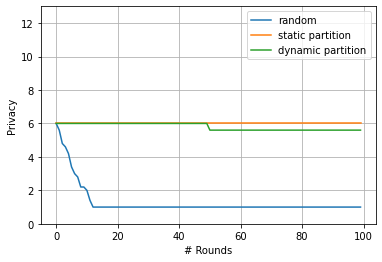

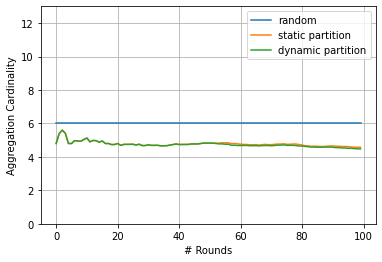

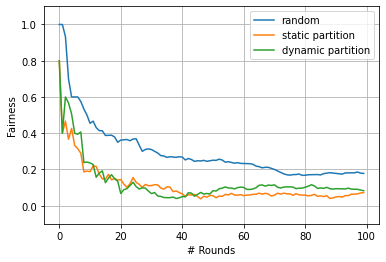

In [39]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.plot(mean_priavcy_N120_pdiff[0,:], label='random')
plt.plot(mean_priavcy_N120_pdiff[1,:], label='static partition')
plt.plot(mean_priavcy_N120_pdiff[2,:], label='dynamic partition')


# plt.plot(mean_priavcy_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Privacy')
plt.xlabel('# Rounds')
plt.ylim([0,13])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_Agg_Card_N120_pdiff[0,:], label='random')
plt.plot(mean_Agg_Card_N120_pdiff[1,:], label='static partition')
plt.plot(mean_Agg_Card_N120_pdiff[2,:], label='dynamic partition')

# plt.plot(mean_Agg_Card_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Aggregation Cardinality')
plt.xlabel('# Rounds')
plt.ylim([0,13])
plt.grid()
plt.legend()
plt.show()

plt.plot(mean_fairness_N120_pdiff[0,:], label='random')
plt.plot(mean_fairness_N120_pdiff[1,:], label='static partition')
plt.plot(mean_fairness_N120_pdiff[2,:], label='dynamic partition')


# plt.plot(mean_fairness_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Fairness')
plt.xlabel('# Rounds')
plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()

In [42]:
print(Privacy[2,:])

[[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
  6. 6. 6. 6.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.

In [27]:
print(np.shape(P_dynamic_partition))

print(np.sum(P_dynamic_partition[100:200],axis=0))

print(P_dynamic_partition[0:2])
print(P_dynamic_partition[100:102])

(200, 120)
[14.  8.  8.  9.  9.  9.  7. 11.  9. 10.  7. 14.  7. 15. 11. 14.  4. 11.
 10. 10. 10.  9.  9. 10. 10.  9.  9. 11. 15.  4. 14. 15.  8.  9. 14. 10.
 14.  9. 10. 11.  7. 10. 15.  4. 11.  4.  9.  4.  4.  7.  9. 15.  8. 10.
  7.  9. 14.  9.  9.  7.  9.  9. 11.  7. 10. 10.  4.  9. 15.  9.  4. 15.
  8. 10. 11.  4. 10.  8.  8. 14.  4.  4.  9.  7.  7. 15.  8. 10. 15. 15.
 14. 10.  9.  7. 15. 11.  7.  8. 10. 10. 14. 10. 14. 10. 11. 10.  8. 10.
 15. 10.  9.  8. 11.  8.  9.  4. 10.  9. 14. 11.]
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0

In [28]:
P = np.array(P_dynamic_partition)
P_rref = rref(P)

print(P_rref)

P_num = np.count_nonzero(np.array(P_rref),axis = 1)

print(P_num)
zero_index = np.where(P_num == 0)
P_num[zero_index] = N+1

partial_sum = np.min(P_num)


[[1. 0. 0. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[22 18 16 58 12 20 52 22 22 12 12 12 12 12 12 12 12 12 12  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
